In [1]:
!pip install -r ./requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 8.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.3 MB/s eta 0:00:00
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6361 sha256=a5a9eeaaaafe2daa96f1c112d055896b3c2ede7a1131091740c9c886f715a96e
  Stored in directory: /root/.cache/pip/wheels/d3/e0/e9/305e348717e399665119bd012510d51ff4f22d709ff60c3096
Successfully built easydict
  Attempting uninstall: monai
    Found existing installation: monai 0.8.1
    Uninstalling monai-0.8.1:
      Successfully uninstalled monai-0.8.1


In [2]:
# For nebula torch installation for A100
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 32.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.4 MB/s eta 0:00:00:00:01m0:01m
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1


In [1]:
%load_ext autoreload
import re, time, os, shutil, json
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from PIL import Image
from monai.data import list_data_collate
import tempfile
import monai
from monai.data import DataLoader, Dataset 
from monai.transforms.intensity.array import ScaleIntensity
from monai.transforms import (
    LoadImage, EnsureChannelFirst, Spacing,
    RandFlip, Resize, EnsureType,
    LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose, ScaleIntensityd, 
    AddChanneld, MapTransform, AsChannelFirstd, EnsureType, 
    Activations, AsDiscrete, RandCropByPosNegLabeld, 
    RandRotate90d, LabelToMaskd, RandFlipd, RandRotated, Spacingd, RandAffined,
    RandShiftIntensityd, Lambdad, MaskIntensityd
)
from utils import get_label

from dataset import setup_dataloaders, setup_datafiles

import configdot
import torch
from monai.config import print_config
%autoreload 2

In [2]:
!mkdir -p ./MONAI_TMP

In [3]:
os.environ['MONAI_DATA_DIRECTORY'] = "./MONAI_TMP"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./MONAI_TMP


# Create dataset

In [4]:
config = configdot.parse_config('configs/config.ini')

In [5]:
print(torch.cuda.is_available())
DEVICE = config.opt.device if hasattr(config.opt, "device") else 0
#DEVICE=0
device = torch.device(DEVICE)
torch.cuda.set_device(DEVICE)

print('Setting GPU#:', DEVICE)
print('Using GPU#:', torch.cuda.current_device())

True
Setting GPU#: 0
Using GPU#: 0


### Loading train-test split


In [6]:
import numpy as np
subjects_list = np.load('./metadata/metadata_fcd_nG.npy', allow_pickle=True).item()

In [7]:
subjects_list

{'train': array(['n80', 'n27', 'n53', 'n66', 'n71', 'n15', 'n46', 'n14', 'n30',
        'n77', 'n87', 'n69', 'n67', 'n60', 'n65', 'n33', 'n61', 'G368',
        'n84', 'n54', 'n64', 'n57', 'n45', 'G180', 'G324', 'n68', 'n81',
        'n12', 'n48', 'n82', 'n76', 'n42', 'n55', 'n3', 'n5', 'G044',
        'n44', 'n70', 'n47', 'G294', 'n20', 'G417', 'n78', 'n37', 'n8',
        'n43', 'n74', 'n31', 'n13', 'G061', 'G081', 'n35', 'n73', 'n24',
        'n36', 'n18', 'n59', 'n49', 'n39', 'n32', 'n88', 'n22', 'n17',
        'n56', 'n62', 'n11', 'n26', 'n10', 'n28', 'n79', 'n40', 'n21',
        'G133', 'n75', 'n25', 'n9', 'n38', 'n2', 'G507', 'n72'],
       dtype=object),
 'test': array(['n51', 'n29', 'n41', 'G256', 'n58', 'G258', 'n50', 'n23', 'n83',
        'G414'], dtype=object)}

In [8]:
train_list = subjects_list.get('train')
val_list = subjects_list.get('test')

feat_params = config.dataset.features

print(len(train_list), len(val_list))

80 10


In [9]:
feat_params

['image', 'thickness']

In [10]:
train_loader, val_loader = setup_dataloaders(config)
train_files, val_files = setup_datafiles(subjects_list, config)

Train set length: 80
Test set length: 10
Train set length: 80
Test set length: 10


### Transformation and Augmentation

In [12]:
assert config.default.interpolate
spatial_size_conf = tuple(config.default.interpolation_size)
#masked = config.dataset.trim_background
masked = True

def masked_transform(data_dict):
    data_dict["image"] = data_dict["image"] * data_dict["mask"]
    return data_dict

if masked:
    keys=["image", "seg", "mask"]
    sep_k=["seg", "mask"]
else:
    keys=["image", "seg"]
    sep_k=["seg"]

if config.opt.augmentation:
    rot_range = config.opt.rotation_range

    train_transf = Compose(
        [
            LoadImaged(keys=keys),
            EnsureChannelFirstd(keys=keys),
            RandRotated(keys=keys, 
                        #range_x=rot_range, 
                        #range_y=0.4, 
                        range_z=0.8, 
                        prob=1),
            RandFlipd(keys=keys, prob=0.5, spatial_axis=0),
            Spacingd(keys=sep_k, pixdim=1.0),
            Resized(keys=keys, spatial_size=spatial_size_conf),
            ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
            masked_transform,
            EnsureTyped(keys=keys, dtype=torch.float),
        ]
    )

    val_transf = Compose(
        [
                LoadImaged(keys=keys),
                EnsureChannelFirstd(keys=keys),
                Spacingd(keys=sep_k, pixdim=1.0),
                Resized(keys=keys, spatial_size=spatial_size_conf),
                ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0, channel_wise=True),
                masked_transform,
                EnsureTyped(keys=keys, dtype=torch.float),
            ]
    )
    
else:
    raise NotImplementedError

### Visualization

In [13]:
def get_label(path):
    '''
    Extracts label from path, e.g.:
    '/workspace/RawData/Features/preprocessed_data/label_bernaskoni/n16.nii.gz' -> 'n16'
    '''
    return path.split('/')[-1].split('.')[0]

In [14]:
check_batch_size = 2
check_dataset = Dataset(data=train_files, transform=train_transf)
check_loader = DataLoader(check_dataset, 
                          batch_size=check_batch_size, 
                          num_workers=0, 
                          collate_fn=list_data_collate, 
                          pin_memory=torch.cuda.is_available(),
                          shuffle=False
                          )

#check_data = monai.utils.misc.first(check_loader)
check_data = monai.utils.misc.first(train_loader)

In [15]:
print(check_data["image"].shape, check_data["seg"].shape, check_data["mask"].shape, len(feat_params))

torch.Size([2, 2, 128, 128, 128]) torch.Size([2, 1, 128, 128, 128]) torch.Size([2, 1, 128, 128, 128]) 2


In [16]:
feat_params

['image', 'thickness']

image shape: torch.Size([2, 128, 128, 128])


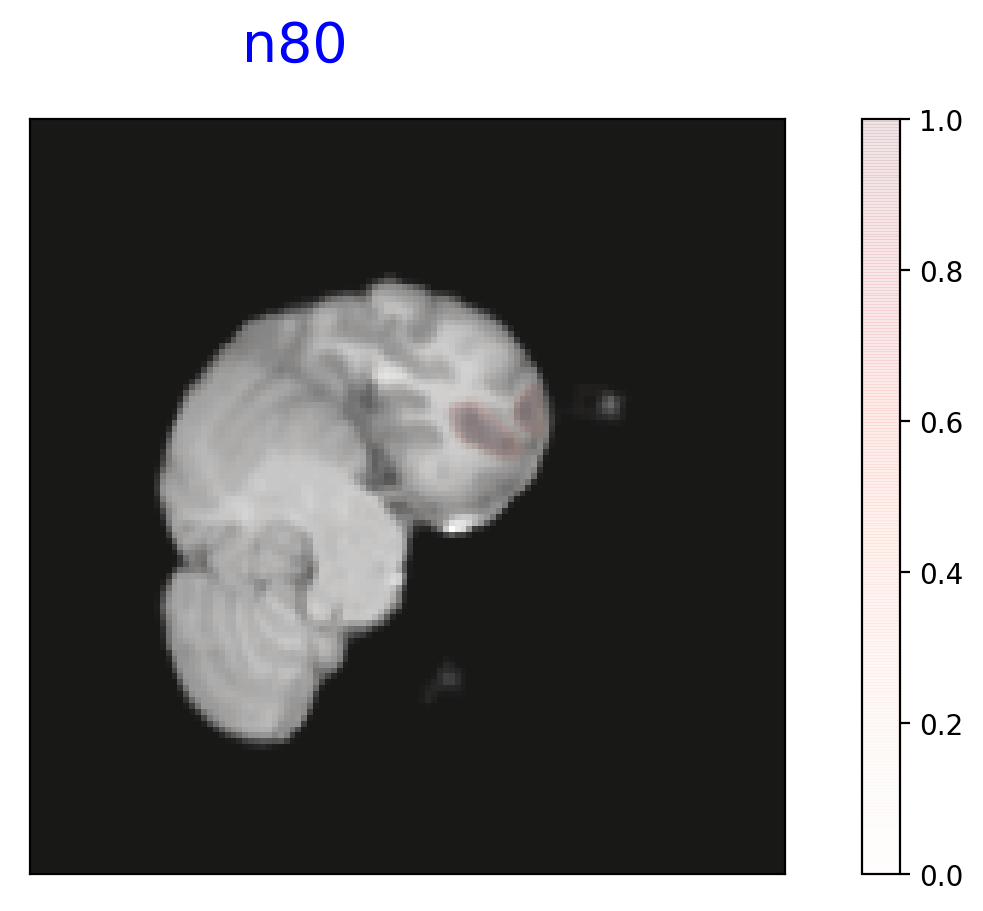

image shape: torch.Size([2, 128, 128, 128])


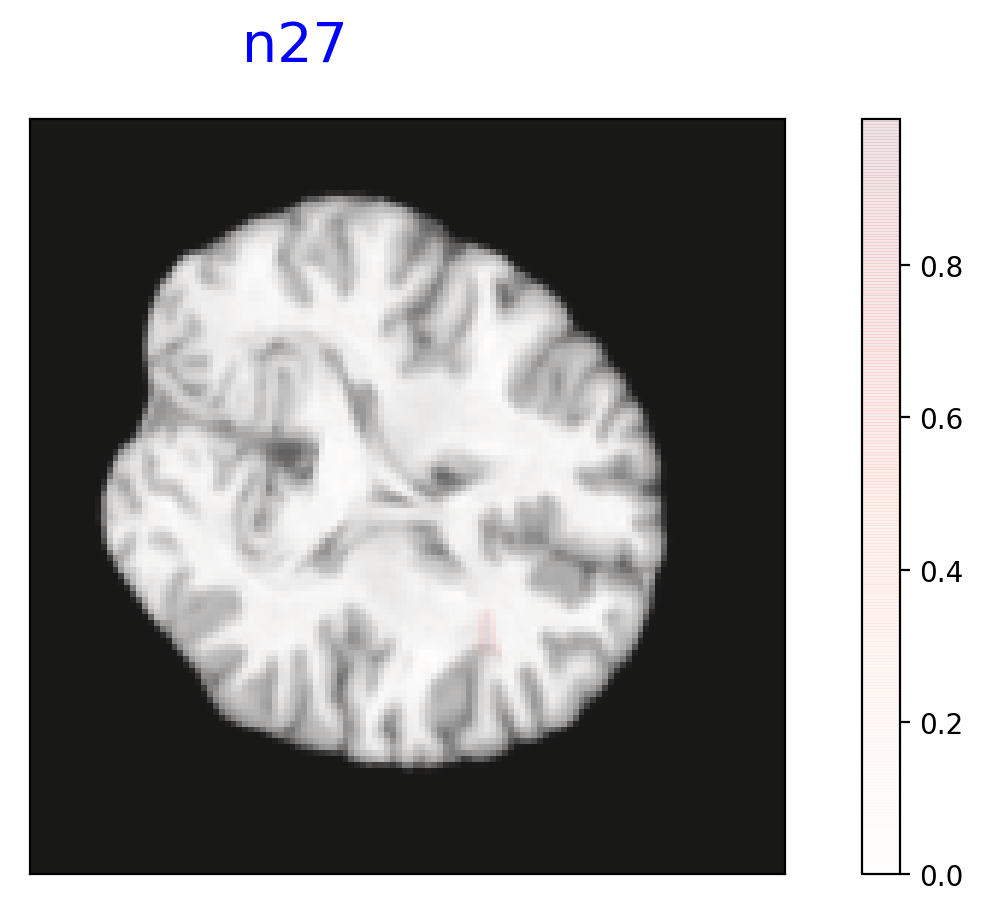

In [23]:
for k in range(check_batch_size):
    
    image = check_data['image'][k]
    seg = check_data['seg'][k]
    mask = check_data['mask'][k]
    label = get_label(check_dataset.data[k]['seg'])
    
    print(f"image shape: {image.shape}")
    
    num_of_channels = len(feat_params)
    # choose z-coord where there is a label maximum over other axes
    label_pos = (seg > 0).sum(dim=(0,1,2)).argmax().item()
    
    #mask = image[:1,...] <= 0 # `background mask
    
    torch.sum(mask * image, dim=(-1,-2,-3)).type(torch.int) > 1

    fig = plt.figure("image", (10, 5), dpi=200)
    plt.subplot(1, 1, 1)
    #plt.title(f"{feat_params[i]}")
    plt.imshow(image[0,:,:,label_pos], cmap='gray')
    #plt.imshow(mask[0,:,:,label_pos], alpha=0.3)
    plt.imshow(seg[0,:,:,label_pos], alpha=0.1, cmap='Reds')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
        
    fig.suptitle(label, fontsize=20, color='blue')
    # plt.tight_layout()
    plt.show()
    if k > 2:
        break

In [91]:
np.array(feat_params)[torch.sum(mask * image, dim=(-1,-2,-3)).type(torch.int) > 1]

array(['image', 't2', 'flair', 'blurring-t1', 'blurring-t1',
       'blurring-t2', 'blurring-Flair', 'cr-t2', 'cr-Flair', 'thickness',
       'curv', 'sulc', 'variance', 'entropy'], dtype='<U14')

In [92]:
feat_params

['image',
 't2',
 'flair',
 'blurring-t1',
 'blurring-t1',
 'blurring-t2',
 'blurring-Flair',
 'cr-t2',
 'cr-Flair',
 'thickness',
 'curv',
 'sulc',
 'variance',
 'entropy']

In [ ]:
image[-2,:,:,label_pos]

In [ ]:
for k in range(check_batch_size):
    
    image = check_data['image'][k]
    seg = check_data['seg'][k]
    label = get_label(check_dataset.data[k]['seg'])
    
    print(f"image shape: {image.shape}")
    
    num_of_channels = len(feat_params)
    # choose z-coord where there is a label maximum over other axes
    label_pos = (seg > 0).sum(dim=(0,1,2)).argmax().item()
    
    mask = image[:1,...] <= 0 # `background mask
    torch.sum(mask * image, dim=(-1,-2,-3)).type(torch.int) > 1

    fig = plt.figure("image", (5, 5), dpi=200)
    
    plt.subplot(1, 1, 1)
    image_bin = image[-2,:,:,label_pos] > 0
    plt.imshow(image_bin, cmap='gray')
    plt.colorbar()
    #plt.title(f"{feat_params[i]}, {image_bin.sum()}")
    # plt.imshow(seg[0,:,:,label_pos], interpolation='none', cmap='Reds', alpha=0.3)
    # plt.imshow(seg[0,:,:,label_pos], interpolation='none', cmap='Reds', alpha=0.3)
    plt.xticks([])
    plt.yticks([])
        
    fig.suptitle(label, fontsize=20, color='blue')
    # plt.tight_layout()
    plt.show()

In [ ]:
# figures_per_row = 6 # for visualization
# for k in range(check_batch_size):
    
#     image = check_data['image'][k]
#     seg = check_data['seg'][k]
#     label = get_label(check_dataset.data[k]['seg'])
    
#     print(f"image shape: {image.shape}")
    
#     num_of_channels = len(feat_params)
#     # choose z-coord where there is a label maximum over other axes
#     label_pos = (seg > 0).sum(dim=(0,1,2)).argmax().item()
    
#     mask = image[:1,...] <= 0 # `background mask
#     torch.sum(mask * image, dim=(-1,-2,-3)).type(torch.int) > 1

#     fig = plt.figure("image", (len(feat_params), 5), dpi=200)
#     for i in range(num_of_channels):
#         nrows = int(np.ceil(num_of_channels/figures_per_row))
#         cols = num_of_channels%figures_per_row
#         plt.subplot(nrows, figures_per_row, i+1)
#         plt.title(f"{feat_params[i]}")
#         plt.imshow(image[i,:,:,label_pos] > 0, cmap="gray")
#         # plt.imshow(seg[0,:,:,label_pos], interpolation='none', cmap='Reds', alpha=0.3)
#         # plt.imshow(seg[0,:,:,label_pos], interpolation='none', cmap='Reds', alpha=0.3)
#         plt.xticks([])
#         plt.yticks([])
        
#     fig.suptitle(label, fontsize=20, color='blue')
#     # plt.tight_layout()
#     plt.show()

# Setup dataloaders

In [ ]:
# training dataset
train_ds = monai.data.Dataset(data=train_files, transform=train_transf)
train_loader = DataLoader(
    train_ds,
    batch_size=config.opt.train_batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

# validation dataset
val_ds = monai.data.Dataset(data=val_files, transform=val_transf)
val_loader = DataLoader(val_ds, 
                        batch_size=config.opt.val_batch_size, 
                        num_workers=0, 
                        collate_fn=list_data_collate,
                        shuffle=False # important not to shuffle, to ensure label correspondence
                        )

### Before augmentation

In [ ]:
# from nilearn.plotting import plot_img
# ind = 0
# plot_img = plot_img(train_files[ind]['seg'],
#          bg_img=train_files[ind]['image'][0],
#          threshold=0.1, alpha=0.5, display_mode='z')
# plot_img
# print(plot_img.cut_coords) # get coordinate of z where lesion center mass

### After augmentation

In [ ]:
ind=0
plt.figure(figsize=(30,30))
for i in range(7):
    plt.subplot(1, 10, i+1)
    item = check_loader.dataset[ind]
    image, seg, mask = (item["image"], item["seg"], item["mask"])
    label_pos = (seg > 0).sum(dim=(0,1,2)).argmax().item()
    plt.imshow(np.rot90(image[0,:, :, label_pos]), cmap='gray')
    plt.imshow(np.rot90(seg[0,:, :, label_pos]), cmap="Reds", alpha=0.4)
    plt.imshow(np.rot90(mask[0,:, :, label_pos]), cmap="Greens", alpha=0.6)
    plt.title("seg overlay")
plt.show()